In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from cycler import cycler

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

global colors
colorblind_palette = plt.cm.tab10.colors

# Selecting the first four colors from the colorblind-friendly palette
colors = colorblind_palette[:4]

print(colors)

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392))


In [2]:
x = np.arange(3)
y = np.arange(10)
z = np.arange(10)

xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')

eam_xyz =  np.column_stack((xx.ravel(), yy.ravel(), zz.ravel())).reshape(-1, 3)

eam_xyz = np.load('../../Numpy_Files/xyz_mcmc.npy')
eam_ef = np.load('../../Numpy_Files/ef_mcmc.npy')
eam_rvol = np.load('../../Numpy_Files/rvol_mcmc.npy')

idx = np.where(np.bitwise_and(eam_xyz[:,0]==0, eam_xyz[:,1]==0))[0]

x = eam_xyz[idx, 2].flatten()
y = eam_ef[idx]

x_idx = np.argsort(x)

x = x[x_idx]
y = y[x_idx]


bind = -np.diff(y) + 6.127788053429867
plt.scatter(np.arange(1,len(x)), bind )

print(bind)

FileNotFoundError: [Errno 2] No such file or directory: '../xyz_mcmc.npy'

In [ ]:
def create_df(xyz, ef, rvol):

    key = {'vac':0, 'h':1, 'he':2, 'ef':3, 'rvol':4}

    data = np.column_stack((xyz[:,0].flatten(),
                            xyz[:,1].flatten(),
                            xyz[:,2].flatten(),
                            ef.flatten(),
                            rvol.flatten()))  
    
    sorted_indices = np.lexsort((data[:, 2], data[:, 1], data[:, 0]))

    data = data[sorted_indices]

    return data, key

In [ ]:
eam_xyz = eam_xyz
eam_ef = eam_ef
eam_rvol = eam_rvol

eam_data, key = create_df(eam_xyz, eam_ef, eam_rvol)

dft_xyz = np.array(pd.read_csv('../dft_xyz.csv'))
dft_ef =  np.array(pd.read_csv('../dft_ef.csv'))
dft_rvol =  np.array(pd.read_csv('../dft_rvol.csv'))

dft_data, key = create_df(dft_xyz, dft_ef, dft_rvol)

dft_data = np.vstack([[0, 0, 0, 0, 0], dft_data])

bonny_xyz = np.column_stack((xx.ravel(), yy.ravel(), zz.ravel())).reshape(-1, 3)
bonny_ef = np.load('../ef_bonny.npy')
bonny_rvol = np.load('../rvol_bonny.npy')

bonny_data, key = create_df(bonny_xyz, bonny_ef, bonny_rvol)

print(bonny_data[:,key['rvol']])

[ 0.          0.34405645  0.66122079  1.05080732  1.42355658  1.95182715
  2.10090617  2.47483566  2.77806825  3.13826221  0.19499707  0.45813457
  0.79421669  1.17258848  1.5688935   2.03807667  2.24870602  2.57073761
  2.93273851  3.49298807  0.31128245  0.59950924  0.93312747  1.33919846
  1.72832577  2.15501962  2.36781694  2.71289312  3.16696392  3.71756819
  0.4605887   0.73336995  1.08169649  1.49655791  1.84465493  2.33391727
  2.54102351  2.9814964   3.28355195  3.83709297  0.59974164  0.89286766
  1.22086953  1.58323106  1.9920058   2.38251595  2.68559644  3.06311286
  3.73143257  4.01463944  0.73115575  1.02669713  1.353425    1.75919428
  2.14138852  2.5215943   2.86467212  3.27319813  3.87575216  4.1542866
  0.87437495  1.16895763  1.49383001  1.91001228  2.25704171  2.6973527
  2.98619371  3.37579255  3.99305881  4.27595814  1.0139337   1.28174907
  1.63290093  2.04294312  2.45159085  2.83237526  3.15732329  3.48100424
  4.10740128  4.40987838  1.15918009  1.43828652  1.7

In [ ]:
def find_he_self_binding(data, key, slct, not_slct):


    int_he_idx = (data[:, key['vac']] == 0) & (data[:, key[not_slct]] == 0) & (data[:, key[slct]] == 1)
    
    int_he = data[int_he_idx,key['ef']]

    plt_dict = {}

    for vac in range(3):

        plt_dict['vac_%d' % vac] = {}

        idx = np.bitwise_and(data[:,key['vac']]==vac, data[:,key[not_slct]]==0)

        atom = data[idx,key[slct]]

        ef = data[idx,key['ef']]

        rvol = data[idx,key['rvol']]

        nan_ef = np.where(np.isnan(ef) == False)[0]
        
        x = atom[nan_ef]

        y = ef[nan_ef]
        
        sort_idx = np.argsort(x)

        x = x[sort_idx]
        y = y[sort_idx]
        
        if vac == 0:
            x_plt = np.arange(1, len(x)-1)

            y_plt = (int_he - np.diff(y))[1:]
        else:
            x_plt = np.arange(len(x) - 1)

            y_plt = (int_he - np.diff(y))

        plt_dict['vac_%d' % vac]['x_bind'] = x_plt

        plt_dict['vac_%d' % vac]['y_bind'] = y_plt

        nan_ef = np.where(np.isnan(rvol) == False)[0]

        x = atom[nan_ef]

        y = rvol[nan_ef]

        sort_idx = np.argsort(x)

        x = x[sort_idx]
        y = y[sort_idx]

        plt_dict['vac_%d' % vac]['x_rvol'] = x

        plt_dict['vac_%d' % vac]['y_rvol'] = y

    return plt_dict

In [ ]:
def plot_data_binding(plt_dict, title, xtitle):

    N_plts = len(plt_dict['dft'].keys())

    fig, axs = plt.subplots(1, N_plts, sharex=True, sharey=True, figsize = (15,6))
    
    plt.style.use('tableau-colorblind10')

    for i, vac_key in enumerate(plt_dict['dft'].keys()):
        # Get data for the current vac_key
        x_values = [plt_dict[key][vac_key]['x_bind'] for key in plt_dict.keys()]
        y_values = [plt_dict[key][vac_key]['y_bind'] for key in plt_dict.keys()]
        labels = plt_dict.keys()

        # Plot data for each label
        x_max = []
        y_max = []
        k = 0
        for x, y, label in zip(x_values, y_values, labels):

            axs[i].plot(x, y, label=label, linestyle=':', marker='o',color=colors[k])
            x_max.append(x.max())
            y_max.append(y.max())
            k += 1

        axs[i].set_ylim(0, np.max(y_max)+0.5)
        
        axs[i].legend()
        axs[i].set_title(vac_key, fontsize=14)

    fig.suptitle(title, y=0.975, fontsize=16)
    fig.text(0.5, 0.04,xtitle, ha='center', fontsize=14)
    fig.text(0.075, 0.5, 'Binding (Trapping) Energy/ eV', va='center', rotation='vertical', fontsize=14)

    
    plt.show()

def plot_data_rvol(plt_dict, title, xtitle):

    N_plts = len(plt_dict['dft'].keys())

    fig, axs = plt.subplots(1, N_plts, sharex=True, sharey=True, figsize = (15,6))
    
    plt.style.use('tableau-colorblind10')

    for i, vac_key in enumerate(plt_dict['dft'].keys()):
        # Get data for the current vac_key
        x_values = [plt_dict[key][vac_key]['x_rvol'] for key in plt_dict.keys()]
        y_values = [plt_dict[key][vac_key]['y_rvol'] for key in plt_dict.keys()]
        labels = plt_dict.keys()

        # Plot data for each label
        x_max = []
        y_max = []
        k = 0
        for x, y, label in zip(x_values, y_values, labels):

            if len(y) > 0:
                axs[i].plot(x, y, label=label, linestyle=':', marker='o', color=colors[k])
                x_max.append(x.max())
                y_max.append(y.max())
            k += 1

        # axs[i].set_ylim(0, np.max(y_max)+0.5)
        
        axs[i].legend()
        axs[i].set_title(vac_key, fontsize=14)

    fig.suptitle(title, y=0.975, fontsize=16)
    fig.text(0.5, 0.04,xtitle, ha='center', fontsize=14)
    fig.text(0.075, 0.5, 'Relaxation Volume/ Lattice Volume', va='center', rotation='vertical', fontsize=14)

    
    plt.show()

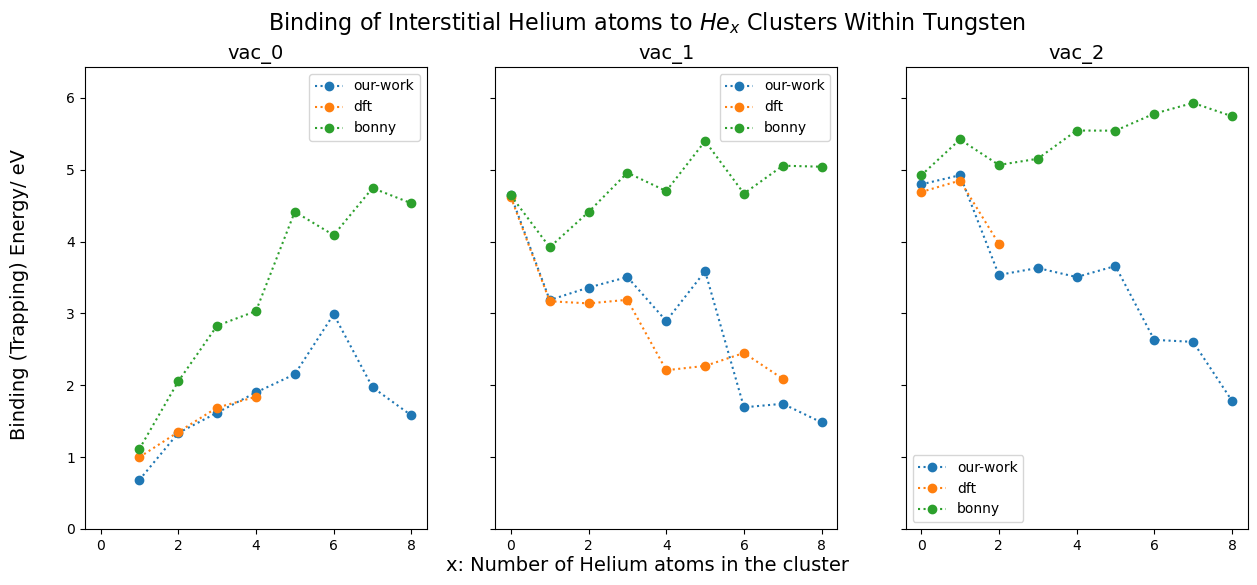

In [ ]:
eam_he_self = find_he_self_binding(eam_data, key, 'he', 'h')
dft_he_self = find_he_self_binding(dft_data, key, 'he', 'h')
bonny_he_self = find_he_self_binding(bonny_data, key, 'he', 'h')

# Convert each dictionary into a DataFrame
he_self = pd.DataFrame({'our-work':eam_he_self, 'dft':dft_he_self, 'bonny':bonny_he_self})

plot_data_binding(he_self,'Binding of Interstitial Helium atoms to $He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

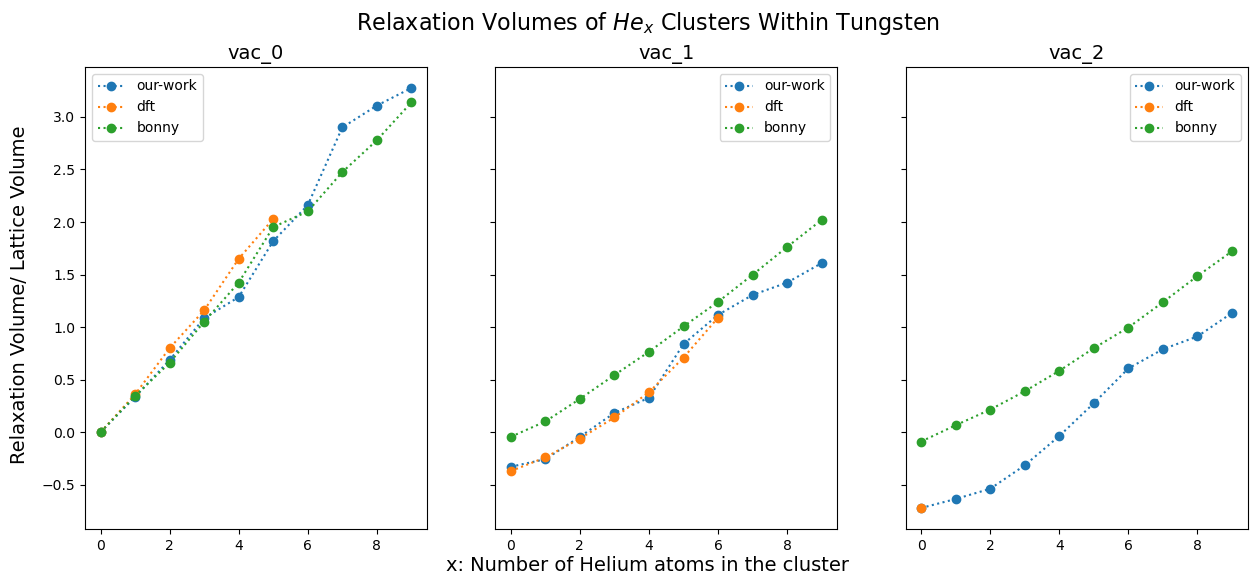

In [ ]:
plot_data_rvol(he_self,'Relaxation Volumes of $He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

In [ ]:
def find_h_he_binding(data, key, n_h):


    int_he_idx = (data[:, key['vac']] == 0) & (data[:, key['he']] == 0) & (data[:, key['h']] == 1)
    
    int_he = data[int_he_idx,key['ef']]

    plt_dict = {}

    for vac in range(3):

        plt_dict['vac_%d' % vac] = {}

        idx_1 = np.bitwise_and(data[:,key['vac']]==vac, data[:,key['h']]==n_h)

        idx_2 = np.bitwise_and(data[:,key['vac']]==vac, data[:,key['h']]==n_h+1)


        ef1 = data[idx_1,key['ef']]

        ef2 = data[idx_2,key['ef']]

        max_length = max(len(ef1), len(ef2))
        
        # Pad the first array with np.nan
        ef1 = np.pad(ef1, (0, max_length - len(ef1)), constant_values=np.nan)
        
        # Pad the second array with np.nan
        ef2 = np.pad(ef2, (0, max_length - len(ef2)), constant_values=np.nan)
        
        atom = data[idx_1,key['he']]

        rvol = data[idx_1,key['rvol']]

        nan_ef = np.where(np.bitwise_and(np.isnan(ef1) == False,np.isnan(ef2) == False))[0]
        
        x = atom[nan_ef]
        
        y1 = ef1[nan_ef]

        y2 = ef2[nan_ef]

        sort_idx = np.argsort(x)

        x = x[sort_idx]
        y1 = y1[sort_idx]
        y2 = y2[sort_idx]

        x_plt = np.arange(len(x))

        y_plt = int_he - y2 + y1

        if vac == 0:
            plt_dict['vac_%d' % vac]['x_bind'] = x_plt[1:]

            plt_dict['vac_%d' % vac]['y_bind'] = y_plt[1:]
        else:
            plt_dict['vac_%d' % vac]['x_bind'] = x_plt

            plt_dict['vac_%d' % vac]['y_bind'] = y_plt

        nan_ef = np.where(np.isnan(rvol) == False)[0]

        x = atom[nan_ef]

        y = rvol[nan_ef]

        sort_idx = np.argsort(x)

        x = x[sort_idx]
        y = y[sort_idx]

        plt_dict['vac_%d' % vac]['x_rvol'] = x

        plt_dict['vac_%d' % vac]['y_rvol'] = y

    return plt_dict

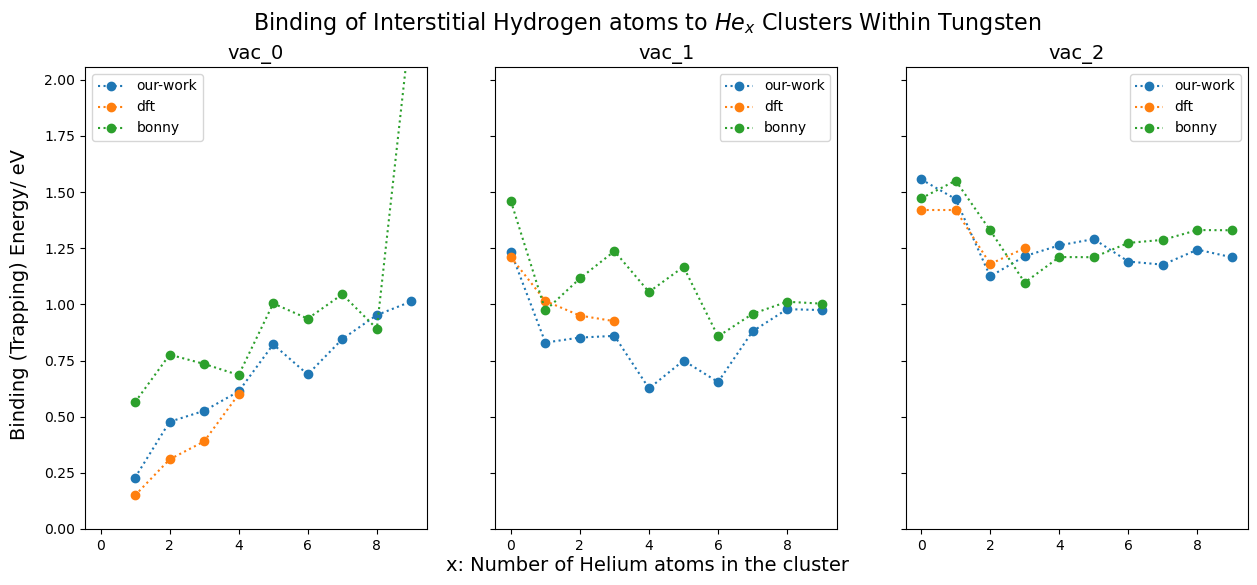

In [ ]:
eam_he_self = find_h_he_binding(eam_data, key, 0)
dft_he_self = find_h_he_binding(dft_data, key, 0)
bonny_he_self = find_h_he_binding(bonny_data, key, 0)

# Convert each dictionary into a DataFrame
h_he_self = pd.DataFrame({'our-work':eam_he_self, 'dft':dft_he_self, 'bonny':bonny_he_self})

plot_data_binding(h_he_self,'Binding of Interstitial Hydrogen atoms to $He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

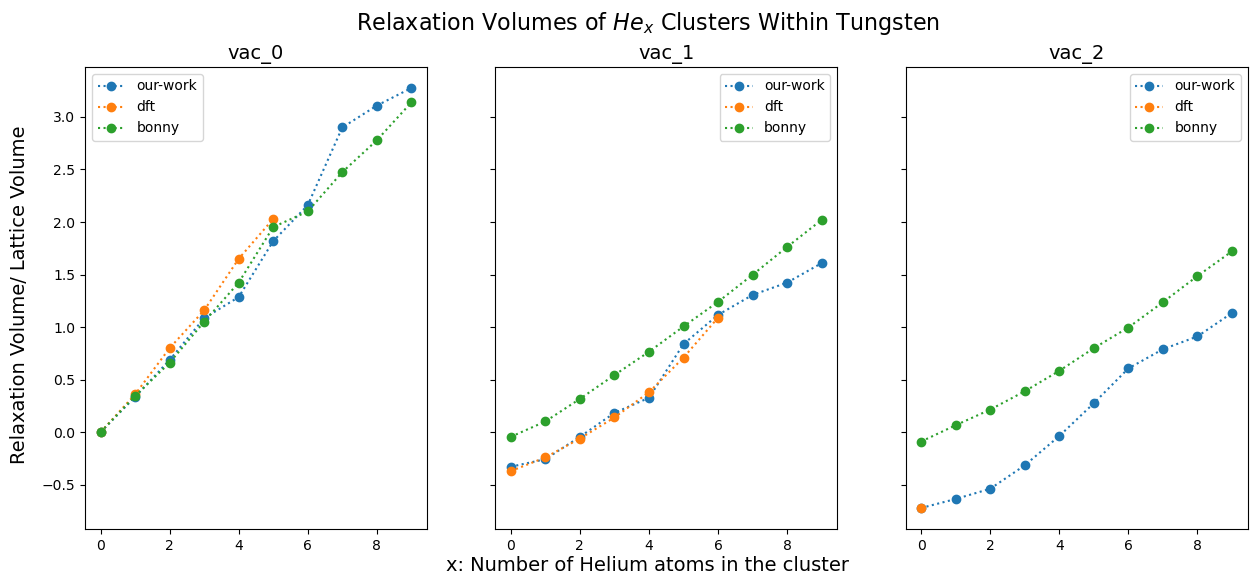

In [ ]:
plot_data_rvol(h_he_self,'Relaxation Volumes of $He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

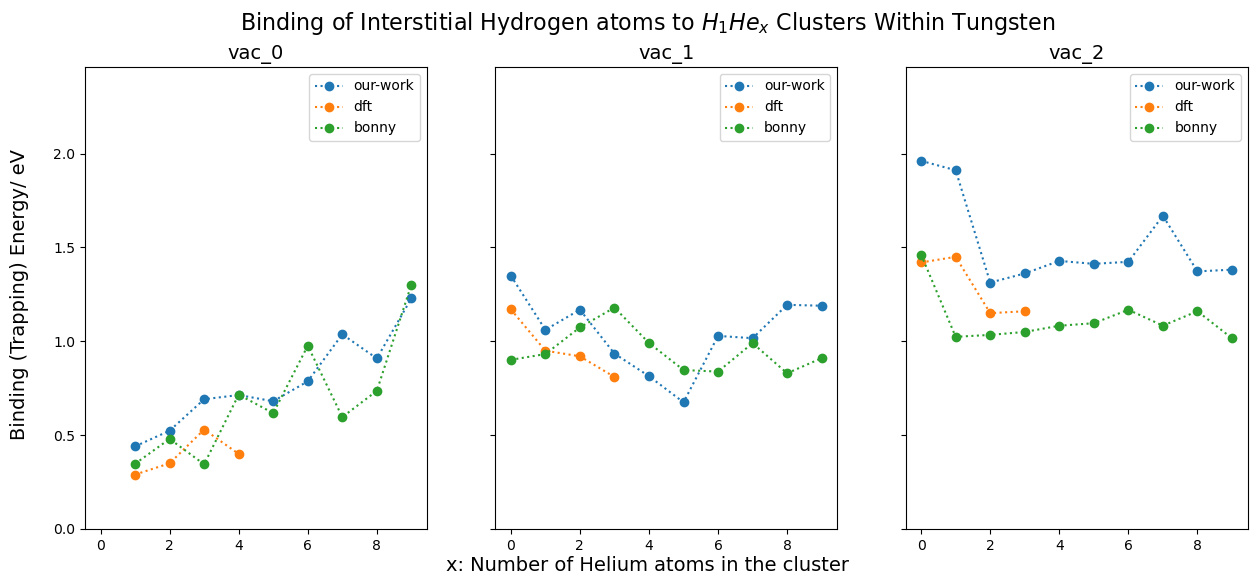

In [ ]:
eam_he_self = find_h_he_binding(eam_data, key, 1)
dft_he_self = find_h_he_binding(dft_data, key, 1)
bonny_he_self = find_h_he_binding(bonny_data, key, 1)

# Convert each dictionary into a DataFrame
h_h1he_self = pd.DataFrame({'our-work':eam_he_self, 'dft':dft_he_self, 'bonny':bonny_he_self})

plot_data_binding(h_h1he_self,'Binding of Interstitial Hydrogen atoms to $H_1He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

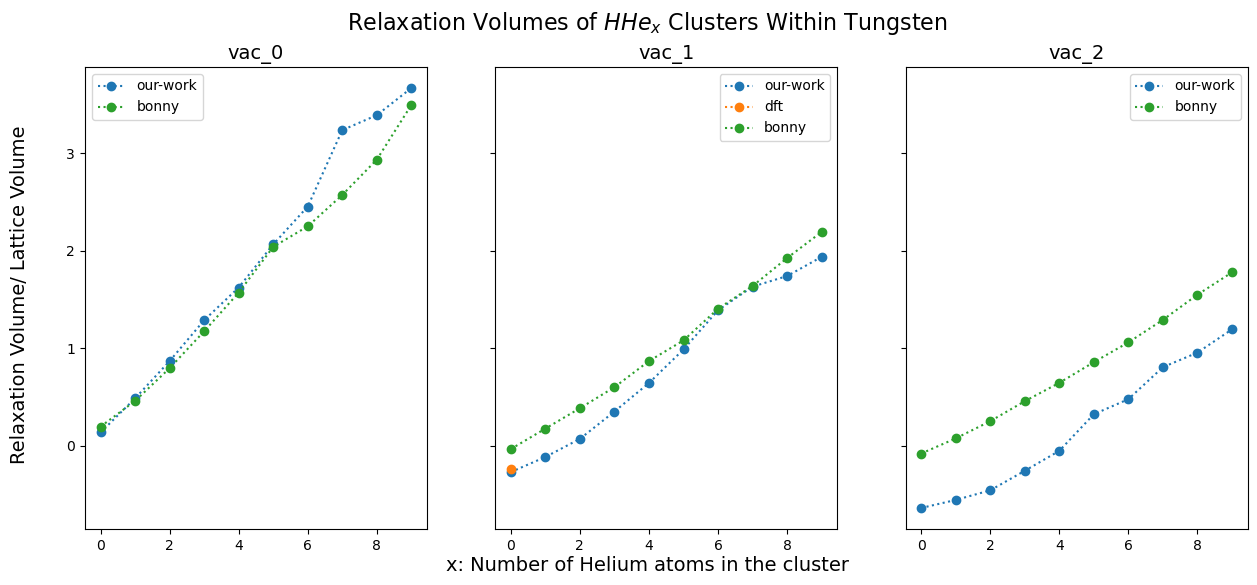

In [ ]:
plot_data_rvol(h_h1he_self,'Relaxation Volumes of $HHe_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

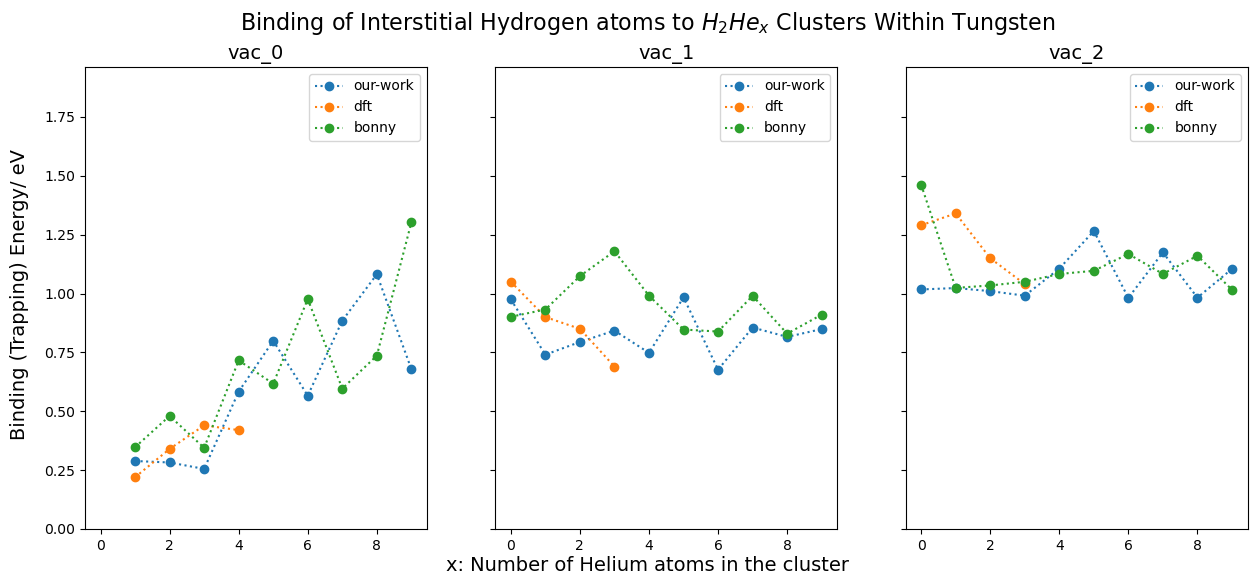

In [ ]:
eam_he_self = find_h_he_binding(eam_data, key, 2)
dft_he_self = find_h_he_binding(dft_data, key, 2)
bonny_he_self = find_h_he_binding(bonny_data, key, 1)
# Convert each dictionary into a DataFrame
h_h2he_self = pd.DataFrame({'our-work':eam_he_self, 'dft':dft_he_self, 'bonny':bonny_he_self})

plot_data_binding(h_h2he_self,'Binding of Interstitial Hydrogen atoms to $H_2He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

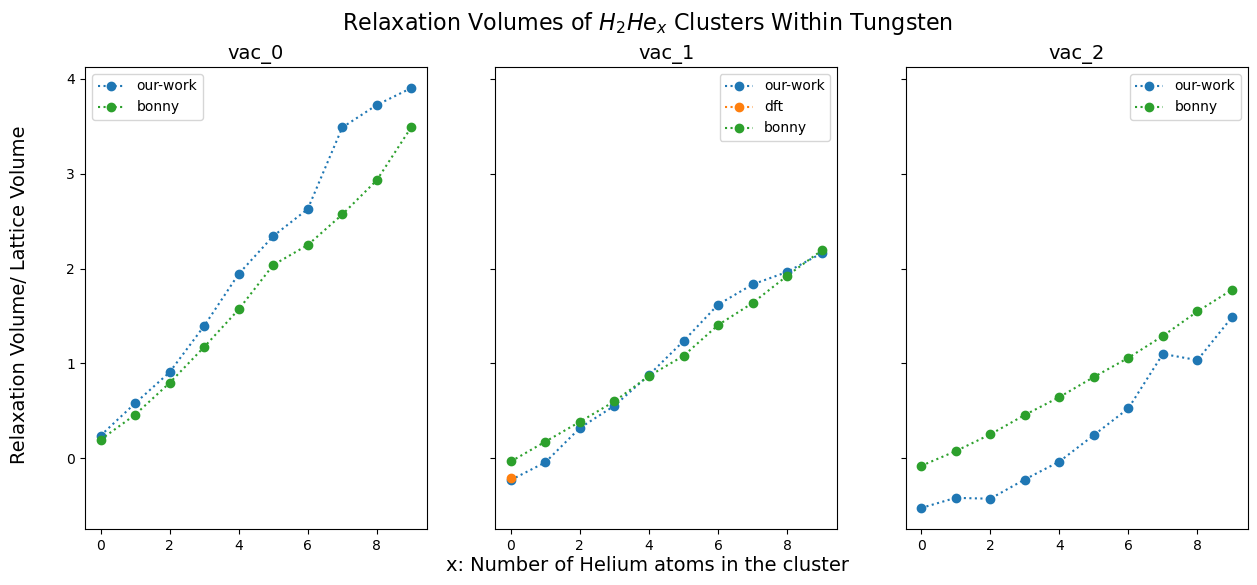

In [ ]:
plot_data_rvol(h_h2he_self,'Relaxation Volumes of $H_2He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

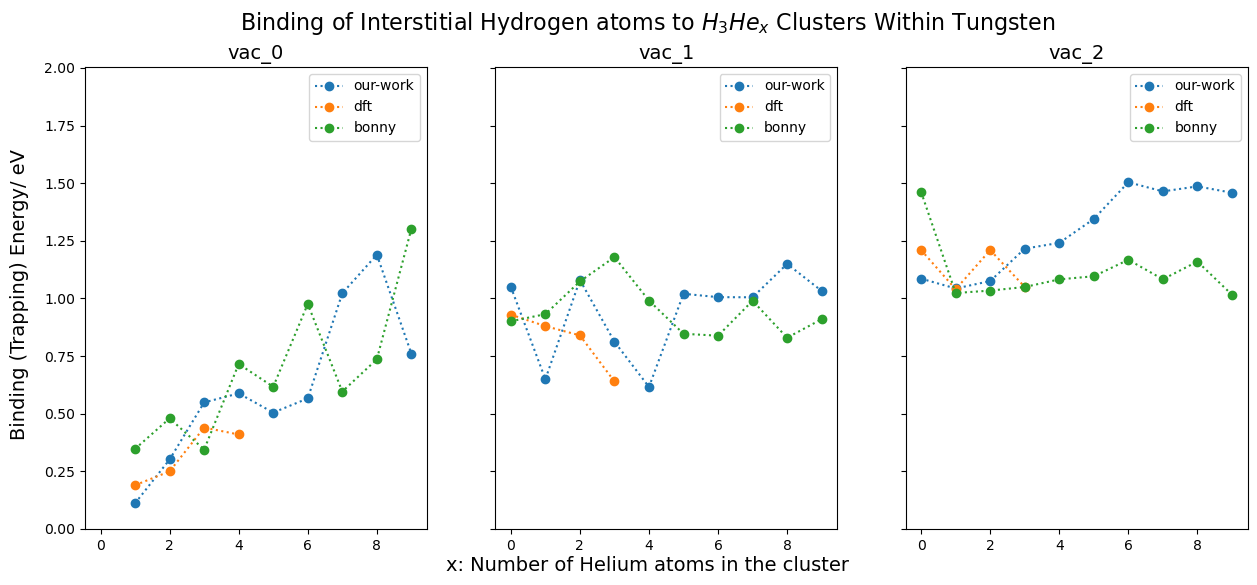

In [ ]:
eam_he_self = find_h_he_binding(eam_data, key, 3)
dft_he_self = find_h_he_binding(dft_data, key, 3)
bonny_he_self = find_h_he_binding(bonny_data, key, 1)

# Convert each dictionary into a DataFrame
h_h3he_self = pd.DataFrame({'our-work':eam_he_self, 'dft':dft_he_self, 'bonny':bonny_he_self})

plot_data_binding(h_h3he_self,'Binding of Interstitial Hydrogen atoms to $H_3He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

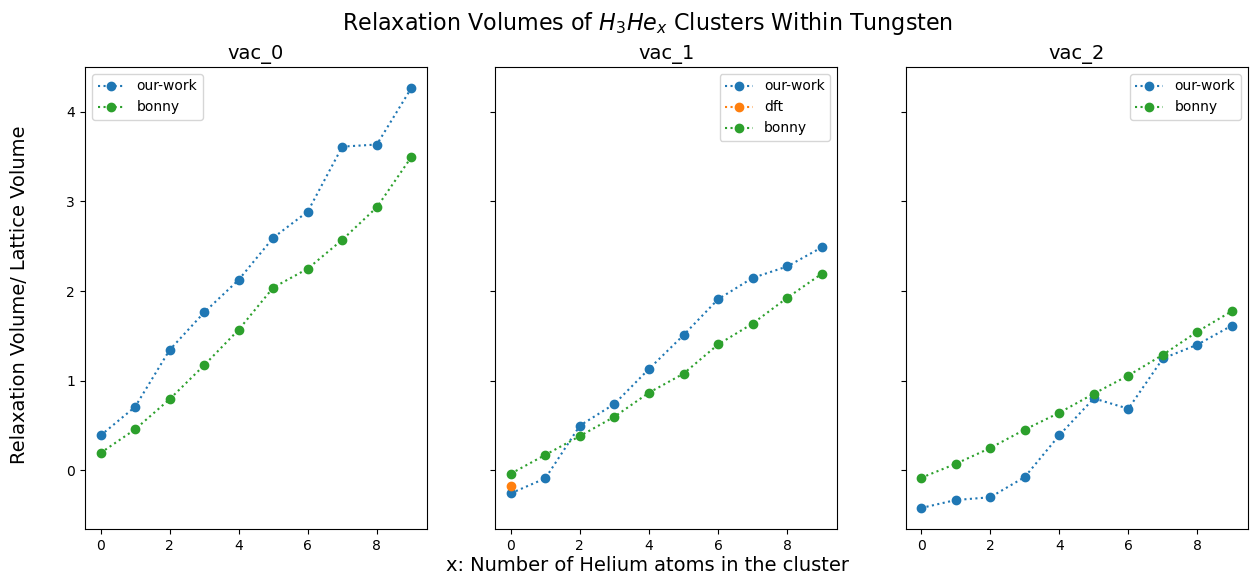

In [ ]:
plot_data_rvol(h_h3he_self,'Relaxation Volumes of $H_3He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

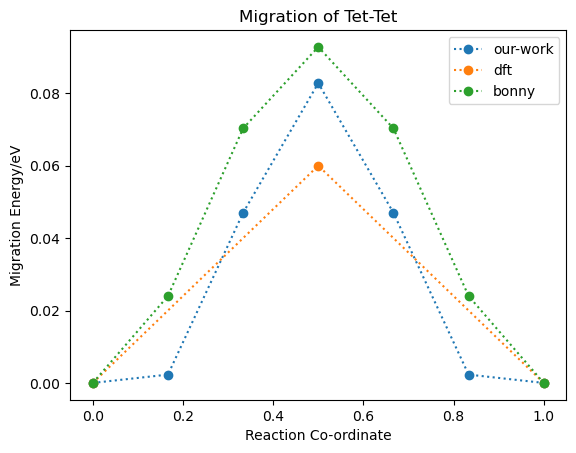

In [ ]:
data = '0              -6133.2398     0.16666666     -6133.2375     0.33333329     -6133.1928     0.49999989     -6133.157      0.66666663     -6133.1928     0.83333333     -6133.2375     1              -6133.2398'   

neb = np.array([float(string) for string in data.split(' ') if len(string) > 0]).reshape(7,2)

neb[:,1] -= neb[0,1]

data = '0              -6099.7155     0.16666664     -6099.6915     0.33333329     -6099.6452     0.49999998     -6099.6227     0.66666658     -6099.6452     0.83333326     -6099.6915     1              -6099.7155     '

neb_bonny = np.array([float(string) for string in data.split(' ') if len(string) > 0]).reshape(7,2)

neb_bonny[:,1] -= neb_bonny[0,1]

plt.plot(neb[:,0], neb[:,1], marker='o', linestyle=':', label='our-work', color=colors[0])
plt.plot([0, 0.5, 1], [0, 0.06,0], marker='o', linestyle=':', label='dft', color=colors[1]) 
plt.plot(neb_bonny[:,0], neb_bonny[:,1], marker='o', linestyle=':', label='bonny', color=colors[2])

plt.xlabel('Reaction Co-ordinate')
plt.ylabel('Migration Energy/eV')
plt.title('Migration of Tet-Tet')
plt.legend()

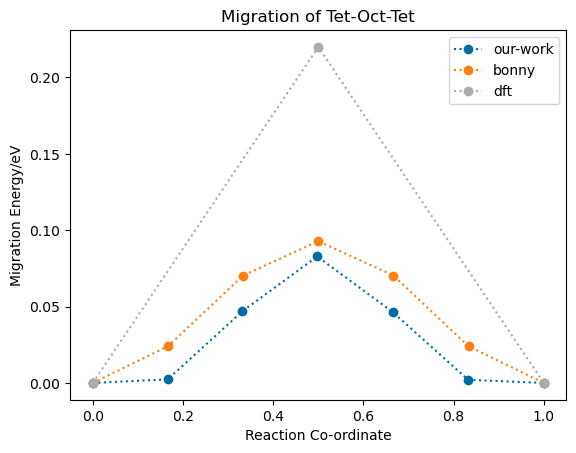

In [ ]:
data =  '0              -6133.2398     0.16588359     -6133.2375     0.33176715     -6133.1929     0.49765069     -6133.157      0.66510049     -6133.1934     0.83255026     -6133.2378     1              -6133.2398'    

neb = np.array([float(string) for string in data.split(' ') if len(string) > 0]).reshape(7,2)

neb[:,1] -= neb[0,1]

data = '0              -6099.7155     0.16666664     -6099.6915     0.33333329     -6099.6452     0.49999998     -6099.6227     0.66666658     -6099.6452     0.83333326     -6099.6915     1              -6099.7155     '

neb_bonny = np.array([float(string) for string in data.split(' ') if len(string) > 0]).reshape(7,2)

neb_bonny[:,1] -= neb_bonny[0,1]

plt.plot(neb[:,0], neb[:,1], marker='o', linestyle=':', label='our-work')
plt.plot(neb_bonny[:,0], neb_bonny[:,1], marker='o', linestyle=':', label='bonny')
plt.plot([0, 0.5, 1], [0, 6.38-6.16,0], marker='o', linestyle=':', label='dft') 

plt.xlabel('Reaction Co-ordinate')
plt.ylabel('Migration Energy/eV')
plt.title('Migration of Tet-Oct-Tet')
plt.legend()